# Cantilever beam physics-informed neural network (PINN)

## Problem overview

The example problem we solve here is a continuous beam:
$$ \rho A \frac{\partial^2w}{\partial t^2} + E I \frac{\partial^4w}{\partial x^4} + \rho A c \frac{\partial w}{\partial t} = f(x,t) $$
$$ w(x, t) = \sum_{j=1}^{\infty}\varphi_j(x)\eta_j(t) \approx \sum_{j=1}^{n}\varphi_j(x)\eta_j(t) $$
where $\varphi_j$ and $\eta_j$ are the $j^{th}$ modal shape and coordinate of the $j^{th}$ mode, respectively.
$$
\mathbf{M}\ddot{\underline{\eta}}(t) + \mathbf{C}\dot{\underline{\eta}}(t) + \mathbf{K}\underline{\eta}(t) = \mathbf{S_p}\mathbf{p}(t)
$$
where,
$$
\mathbf{M} = \rho A \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{C} = \rho Ac \int_0^l\mathbf{\psi}(x)\mathbf{\psi}^T(x) dx, \qquad
\mathbf{K} = EI \int_0^l\mathbf{\psi}(x){\mathbf{\psi}''''}^T(x) dx
$$
in the state space,
$$
\dot{\mathbf{\tau}}(t) = \mathbf{A} \mathbf{\tau}(t) + \mathbf{H} \mathbf{f}(t)
$$
where,
$$
\mathbf{\tau} = \begin{bmatrix} \underline{\eta}(t) \\ \dot{\underline{\eta}}(t) \end{bmatrix}, \qquad
\underline{\eta}(t) = \left[ \eta_1(t), \eta_2(t), ..., \eta_n(t) \right]^T, \qquad
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \qquad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} \mathbf{\eta}(t) \\ \ddot{\mathbf{\eta}}(t) \end{bmatrix} $$

In [1]:
from cont_beam_pinn import beam_ss_pinn, normalise
from beam_solutions import cont_beam, beam_ss_simulate
from math import pi

from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
device = torch.device("mps")

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

from scipy.stats import qmc

import matplotlib.pyplot as plt
from matplotlib import cm
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def gen_beam_params(E, rho, EI, pA):
    I_ = EI/E
    A_ = pA/rho
    h = (2*I_/A_)**(0.5)
    b = A_/h
    I = (1/12) * b * h**3
    A = b * h
    return I, A, b, h

def plot_vib_surface(ax, x, time, w, sub_samp=10):
    if len(x.shape) == 1 and len(time.shape) == 1:
        xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
        x_ = unroll_mat(xx)
        time_ = unroll_mat(tt)
    else:
        if x.shape[1] > 1 and time.shape[1] > 1:
            x_ = unroll_mat(x[::sub_samp,:][:,::sub_samp])
            time_ = unroll_mat(time[::sub_samp,:][:,::sub_samp])
        elif x.shape[1] <= 1 and time.shape[1] <= 1:
            xx, tt = torch.meshgrid(x[::sub_samp], time[::sub_samp], indexing="ij")
            x_ = unroll_mat(xx)
            time_ = unroll_mat(tt)
    if len(w.shape) == 1:
        w_ = w[::sub_samp]
    else:
        if w.shape[1] > 1:
            w_ = unroll_mat(w[::sub_samp,:][:,::sub_samp])
        else:
            w_ = w[::sub_samp]

    ax.plot_trisurf(x_, time_, w_, cmap=cm.plasma, linewidth=0.1, edgecolor='black')
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def plot_vib_scatter(ax, x, time, w, color='grey'):
    ax.scatter3D(x, time, w, color=color)
    ax.set_xlabel('x, m')
    ax.set_ylabel('Time, s')
    ax.set_zlabel('w, m')

def unroll_mat(data):
    nn = data.shape[0]*data.shape[1]
    data_ = torch.zeros(nn)
    di = 0
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_[di] = data[i,j]
            di += 1
    return data_

def roll_mat(data, n1, n2):
    data_ = torch.zeros((n1, n2))
    d_count = 0
    for i in range(n1):
        for j in range(n2):
            data_[i, j] = data[d_count]
            d_count += 1
    return data_

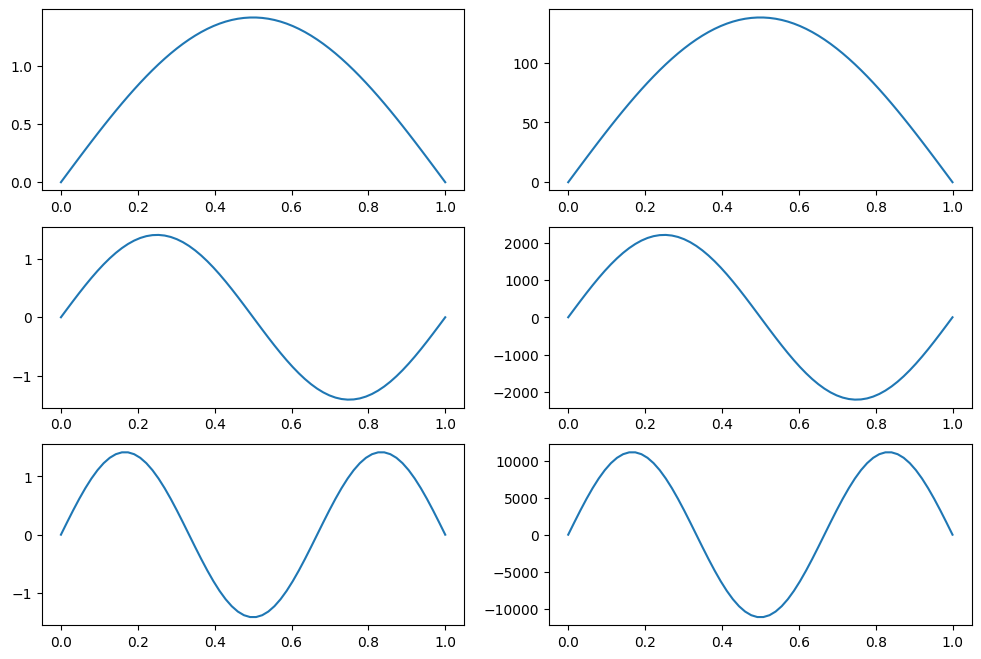

In [53]:
# get the analytical solution over the full domain
E = 1e7
rho = 2700
EI_ = 5e-3
pA = 1.0
c = 0.0
l = 1.0
w1 = (pi**2) * ((EI_)/(pA*(l**4)))**0.5
f1 = w1/(2*pi)
I, A, b, h = gen_beam_params(E, rho, EI_, pA)

nx = 64
nt = 256
n_modes = 6

beam_kwargs_sep = {
    "E" : E,
    "I" : I,
    "rho" : rho,
    "A" : A,
    "c" : c,
    "l" : l
}

beam_kwargs_cmb = {
    "EI" : EI_,
    "pA" : pA,
    "c" : c,
    "l" : l
}

# ss_beam = cont_beam("sep_vars", beam_kwargs_sep)
ss_beam = cont_beam("cmb_vars", **beam_kwargs_cmb)
ss_beam.gen_modes("ss-ss", n_modes, nx)

xx = ss_beam.xx
phis = ss_beam.phi_n
phis_dx4 = ss_beam.phi_dx4_n

M = ss_beam.M
K = ss_beam.K
C = ss_beam.C

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i in range(3):
    axs[i,0].plot(xx, phis[:,i])
    axs[i,1].plot(xx, phis_dx4[:,i])

In [54]:
f0 = 1
init_disp = 0.1
v0 = 0.0
vv0 = torch.zeros(nx)

t = torch.linspace(0,10,nt)

w0_func = lambda x : init_disp * (torch.sin(pi*x)+torch.sin(2*pi*x)+torch.sin(3*pi*x))
w0 = w0_func(ss_beam.xx)

ss_config = {
    'init_state' : {
        'w0' : w0,
        'wdot0' : vv0
    },
    'n_modes' : n_modes,
    'forcing' : None
}

wxt, wxtd, wxtdd, wxt_n, tau, tau_dot = ss_beam.free_vibration(t, w0, vv0)
wxt_ss, wxtd_ss = beam_ss_simulate(t, ss_beam, ss_config)

xx_g, tt = torch.meshgrid((ss_beam.xx, t), indexing="ij")

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


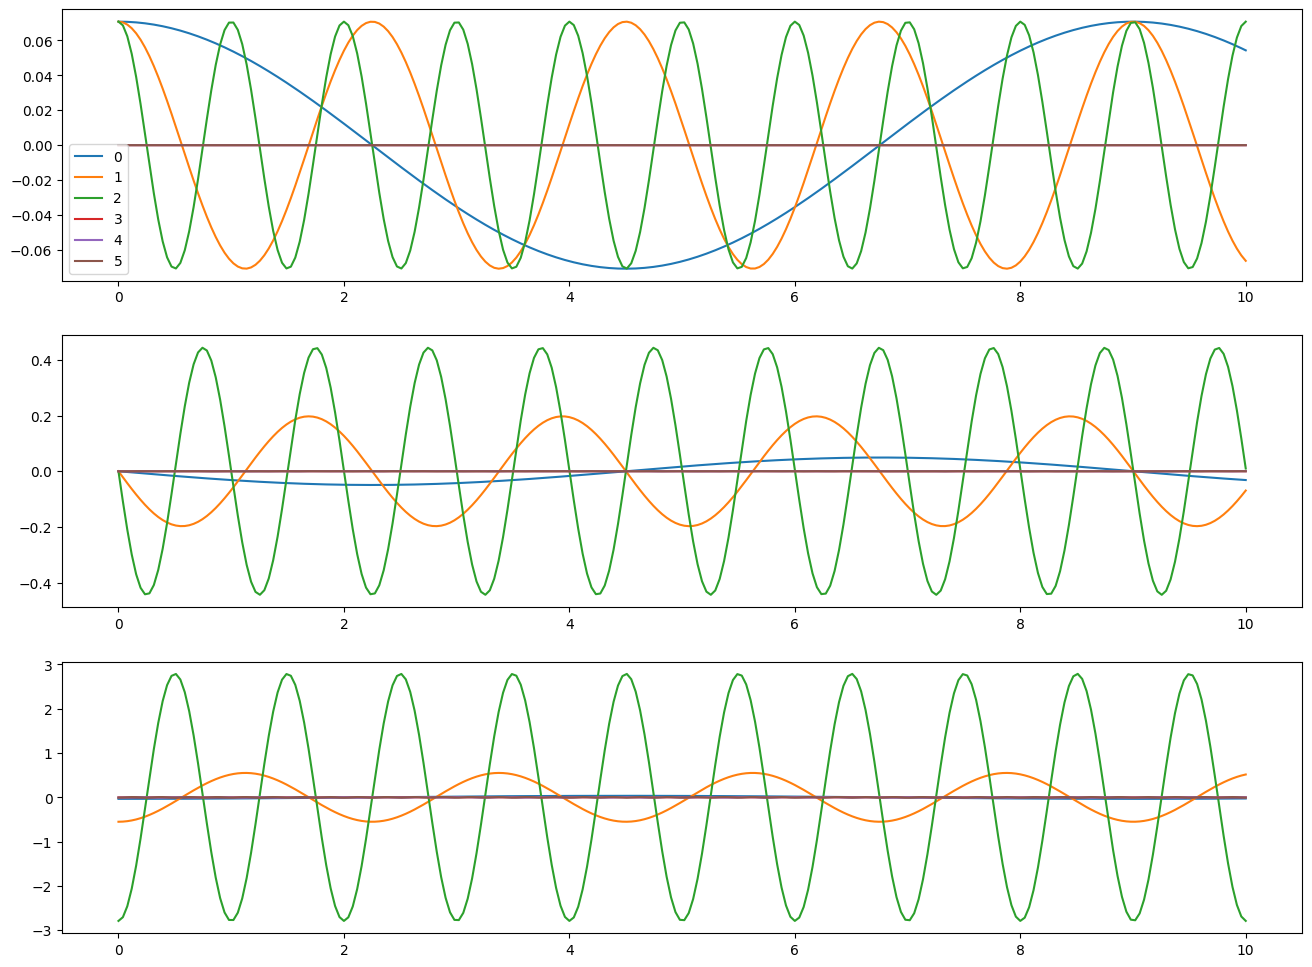

In [55]:
n_sens = 9
# sens_distance = xx[-1]/(n_sens+1)  # distance between sensors
# s_locs = np.arange(sens_distance, xx[-1], sens_distance)  # target location of sensors
# s_ids = [np.argmin(np.abs(xx - s_locs[i])) for i in range(n_sens)]
sampler = qmc.Sobol(d=1, seed=3085)
s_ids = np.sort(sampler.integers(l_bounds=xx.shape[0], n=n_sens), axis=0).reshape(-1)
s_locs = xx[s_ids]

plot_locs = [0.3, 0.45, 0.80]  # target location for plotting
plot_ids_ss = [np.argmin(np.abs(xx[np.array(s_ids)] - plot_locs[i])) for i in range(3)]  # plotting location ids, relative to sensor dataset
plot_locs_ = [xx[s_ids[k]] for k in plot_ids_ss]
plot_ids_gt = [np.argmin(np.abs(xx - plot_locs_[i])) for i in range(3)]  # plotting location ids, relative to gt dataset, by taking closest of sensor dataset

A = torch.cat((
    torch.cat((torch.zeros((n_modes,n_modes)),torch.eye(n_modes)),dim=1),
    torch.cat((-torch.linalg.inv(M)@K,-torch.linalg.inv(M)@C),dim=1)
),dim=0)

R_ = tau_dot - A@tau

fig, axs = plt.subplots(3,1,figsize=(16,12))
for n in range(n_modes):
    axs[0].plot(t,tau[n,:],label=str(n))
    # axs[0].plot(t,R_[n+n_modes,:],c='tab:green')
    axs[1].plot(t,tau[n+n_modes,:])
    axs[2].plot(t,tau_dot[n+n_modes,:])
axs[0].legend()

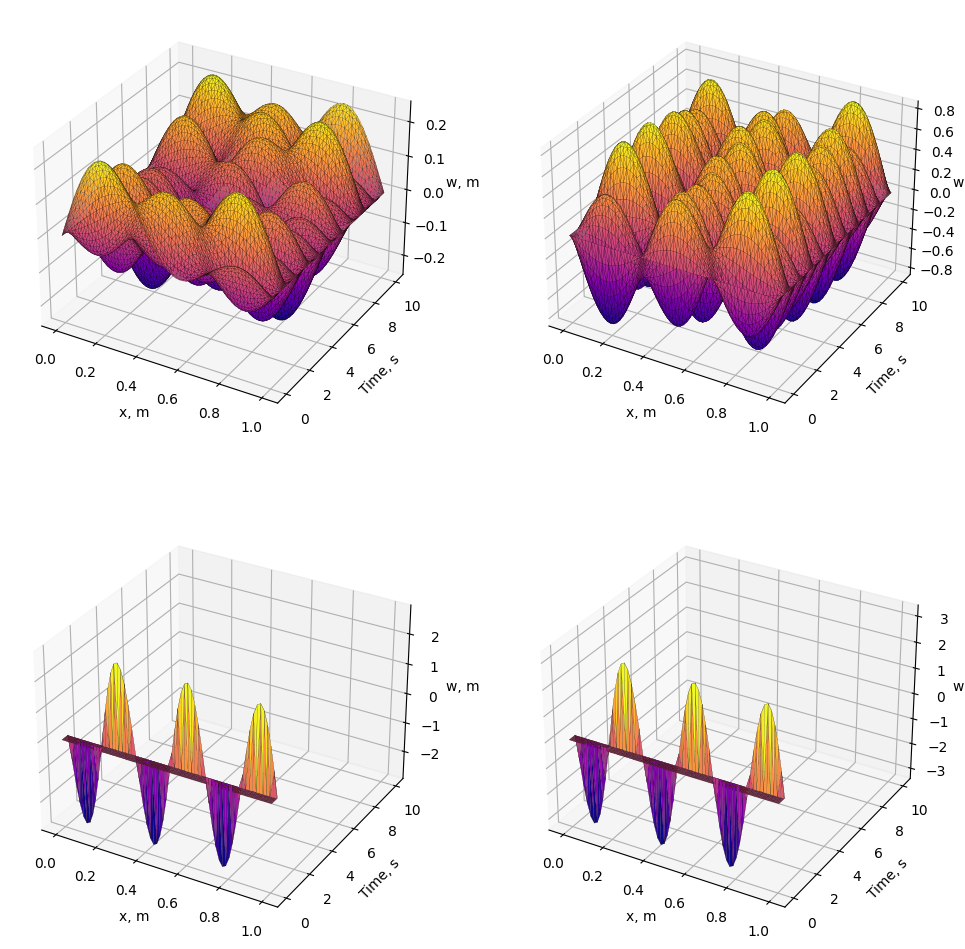

In [56]:
fig, axs = plt.subplots(2, 2, subplot_kw = {"projection":"3d"}, figsize=(12,12))
axs = axs.ravel()
plot_vib_surface(axs[0], xx, t, wxt, 1)
plot_vib_surface(axs[1], xx, t, wxtd, 1)
plot_vib_surface(axs[2], xx, t, wxt_ss, 1)
plot_vib_surface(axs[3], xx, t, wxtd_ss, 1)